In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from scipy import stats

sns.set_style("whitegrid")

In [5]:
df = pd.read_csv('Clean_Dataset.csv')
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [6]:
df.describe(include='all')

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,NaN,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,NaN,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,NaN,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,86646.852011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,75038.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,225114.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


<Axes: xlabel='price'>

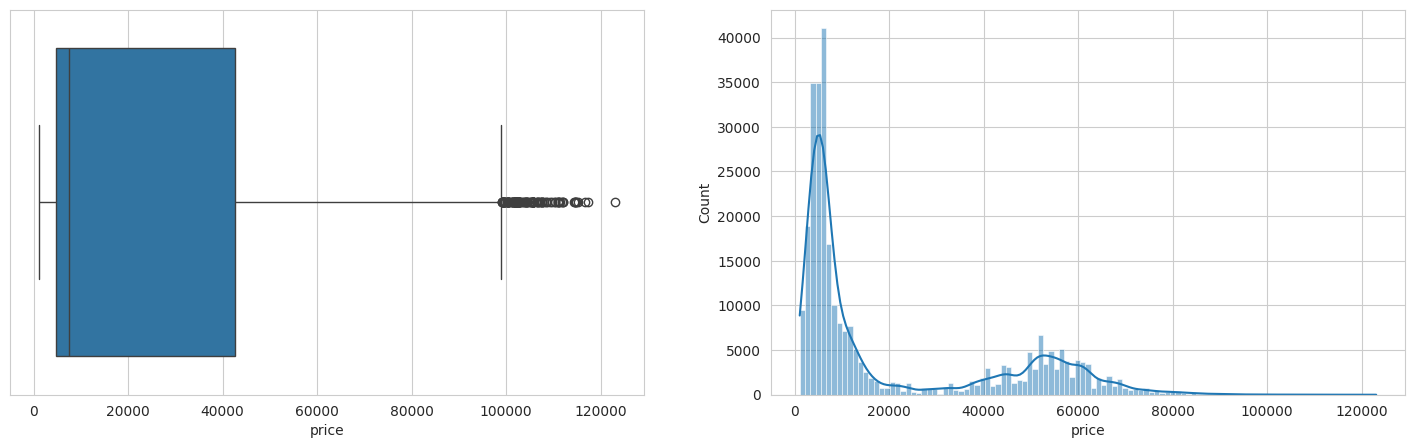

In [7]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

Even though the mean is around 20000, we can see here that the median is approximately 7500. This difference is explainable by the presence of two different tickets: business and economy.

How does the ticket price vary between Economy and Business class?

To visualize the difference between the two kind of tickets, I will plot the prices for the two prices for both business and economy tickets for the different companies.

Text(0.5, 1.0, 'Airline prices based on the class and company')

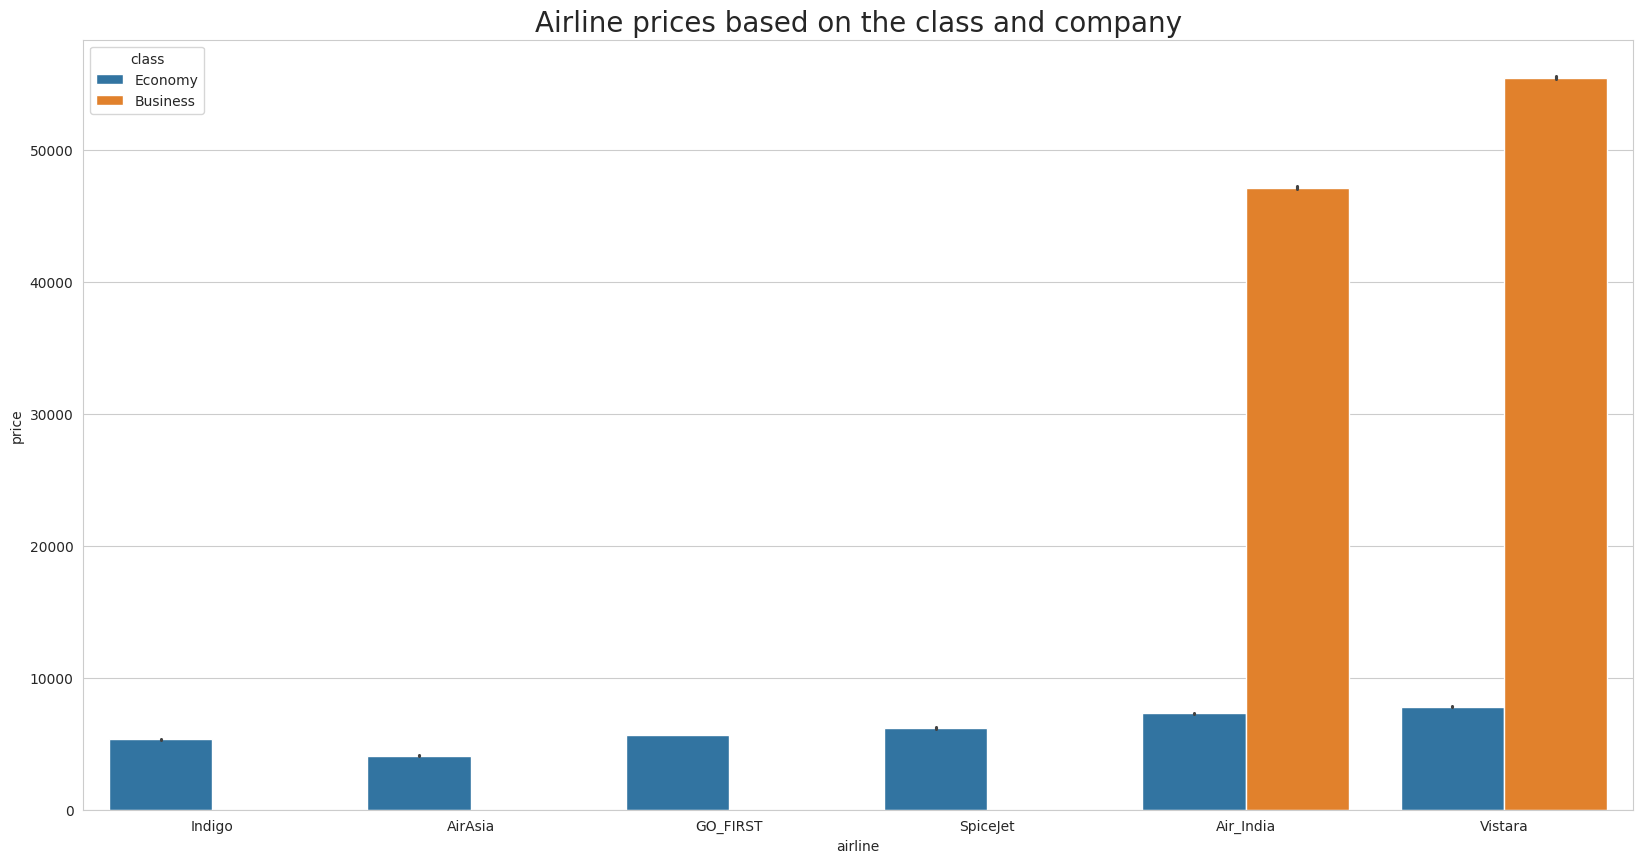

In [8]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=df.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

Business flights are only available in two companies: Air India and Vistara. Also, there is a big gap between the prices in the two class that reaches almost 5 times the price of Economy for Business tickets.

Does price vary with Airlines?

To compare the prices between the companies we will only compare the same kind of tickets since the previous question showed that the class has a big impact on the final price.

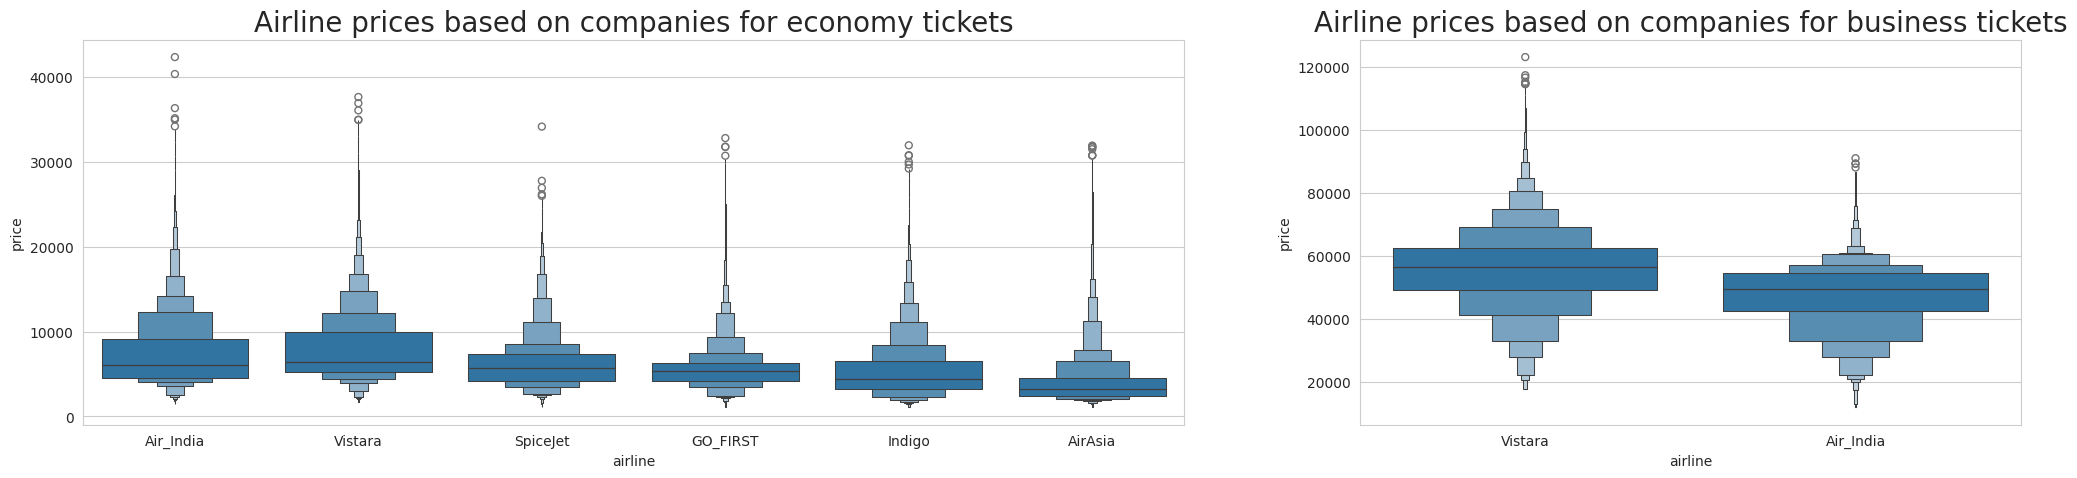

In [11]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.boxenplot(y="price", x="airline", data=df.loc[df["class"]=='Economy'].sort_values("price", ascending=False), ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets", fontsize=20)
sns.boxenplot(y="price", x="airline", data=df.loc[df["class"]=='Business'].sort_values("price", ascending=False), ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets", fontsize=20)
plt.show()

There are slight differences between each companies on this graph, AirAsia seems to have the cheapest flights when Air India and Vistara are more expensive. However it looks like Vistara's business tickets are a little more expensive than the Air India's ones.

How is the price affected when tickets are bought in just 1 or 2 days before departure?

To visualize how the prices changes depending on the number of days left, I will calculate the average price depending on the days left, to try to understand a pattern in the curve.

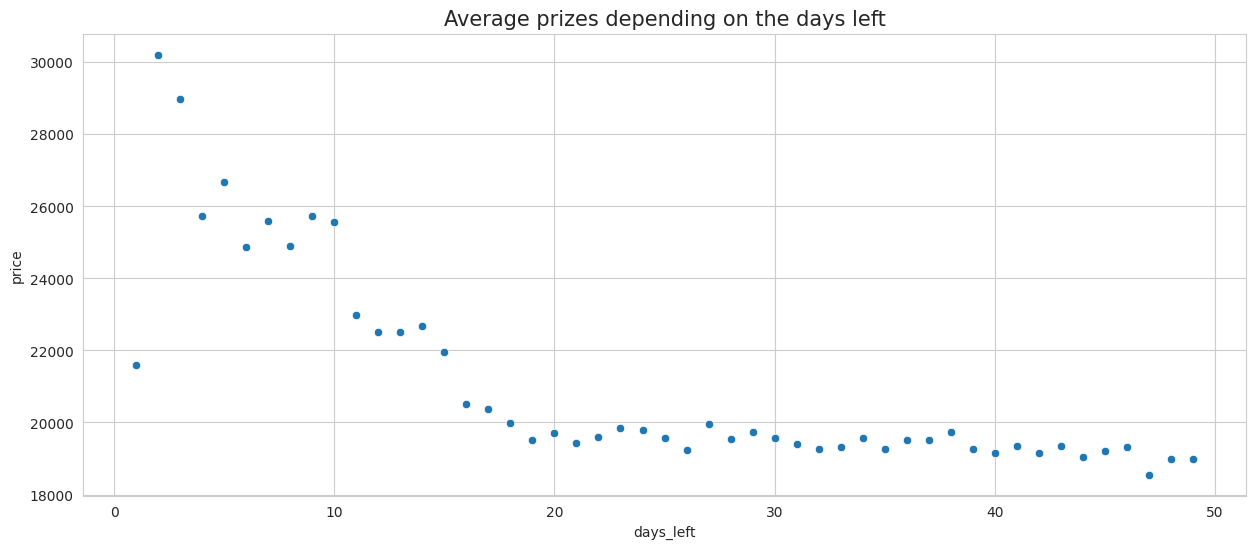

In [12]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

It is possible to see two different curves on this graph, the first one, stable between 50 and 20 days before the flight, and a positive monotone curve between 20 and 2 days before.

<Axes: xlabel='days_left', ylabel='price'>

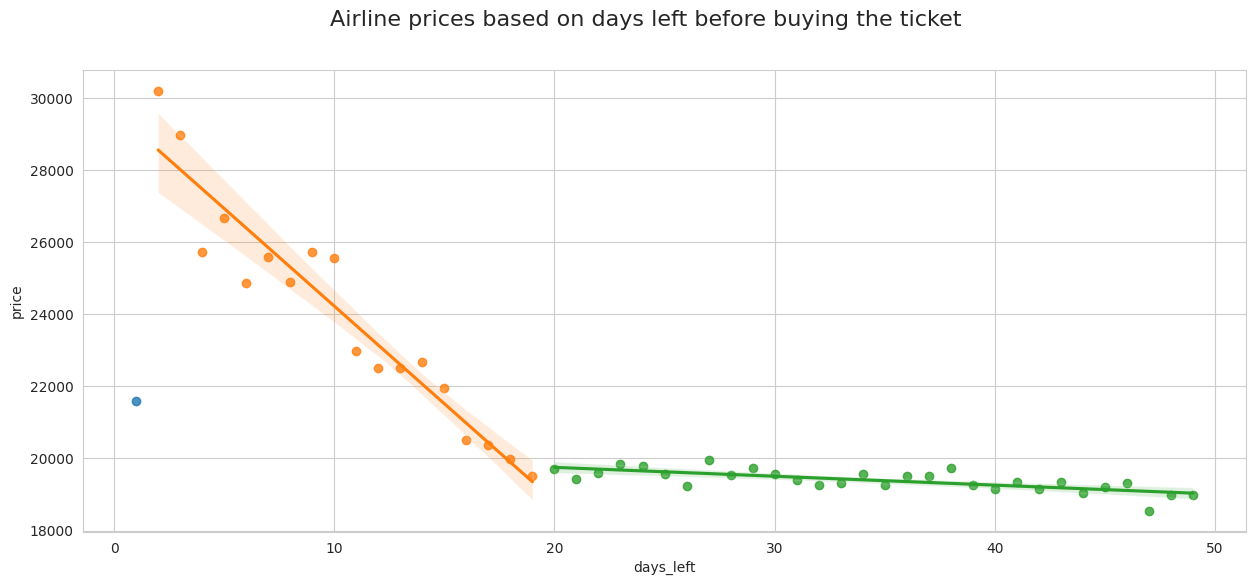

In [13]:
plt.figure(figsize=(15,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=16)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)

The graph highlights how the prices rise slowly and then drastically start rising 20 days before the flight, but fall just one day before the flight up to three times cheaper. This can be explain by the fact the companies want to fill their empty seats and thus lower the prices of the tickets to ensure the planes remains full.

Does the price change with the duration of the flight?

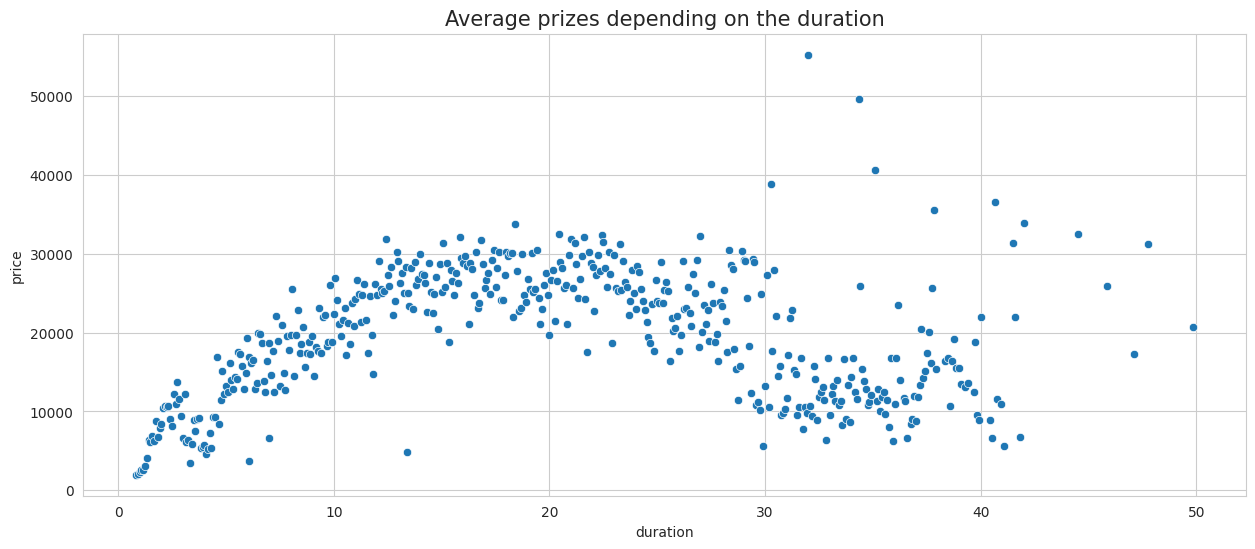

In [14]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

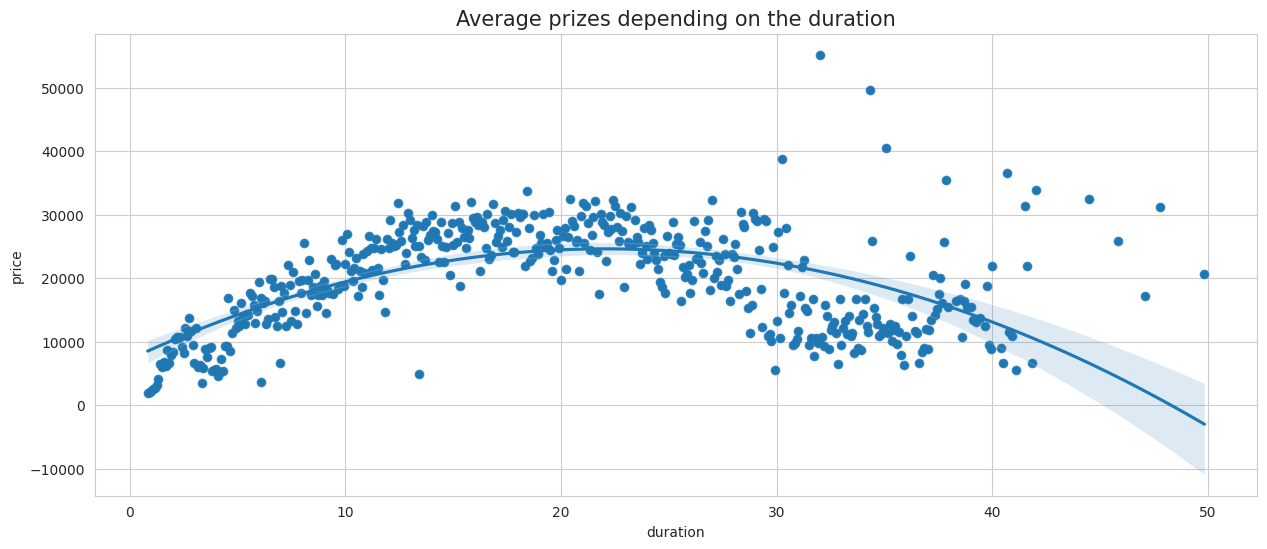

In [15]:
plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)
ax = sns.regplot(x="duration", y="price", data=df_temp, order=2)

 It is clear that here the relationship is not linear but can be approximated with a second degree curve. The prices reaches a high price at a duration of 20 hours before lowering again.

However some outliers seem to affect the regression curve .

Does ticket price change based on the departure time and arrival time?

Text(0.5, 1.0, 'Airline prices based on the arrival time')

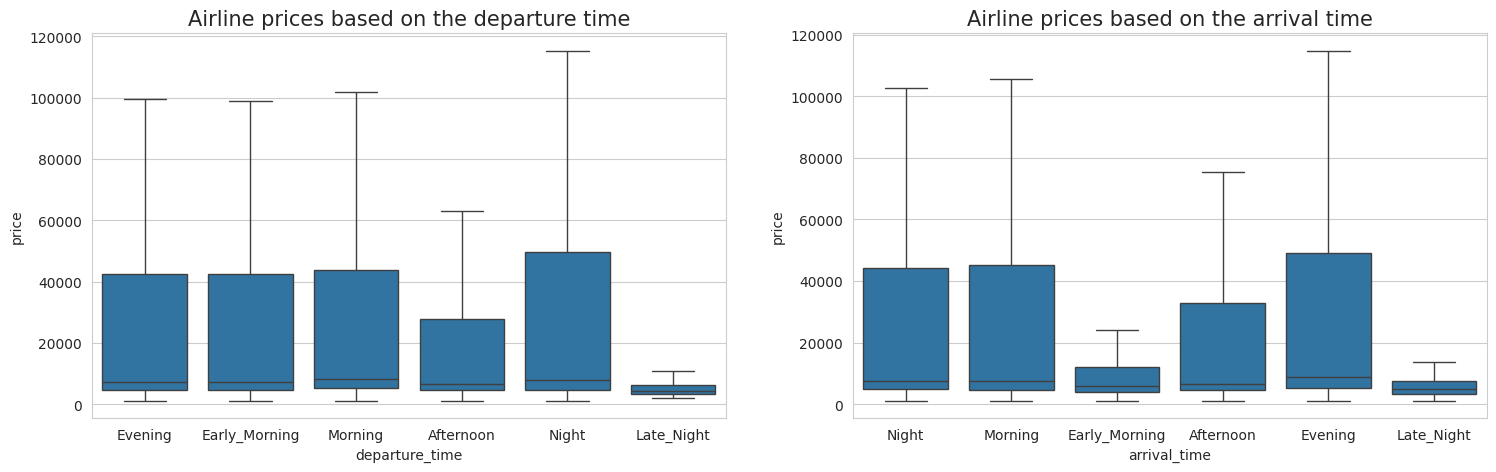

In [16]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, y="price", x="departure_time",showfliers=False).set_title("Airline prices based on the departure time",fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False).set_title("Airline prices based on the arrival time",fontsize=15)

As expected, leaving at night or arriving at night remains the cheapest way to travel. But it's also visible that arriving early morning is also cheap and afternoon flight are a bit cheaper that evening, morning and night flight.

How the price changes with change in Source and Destination?

Text(0.5, 0.98, 'Airline prices based on the source and destination cities')

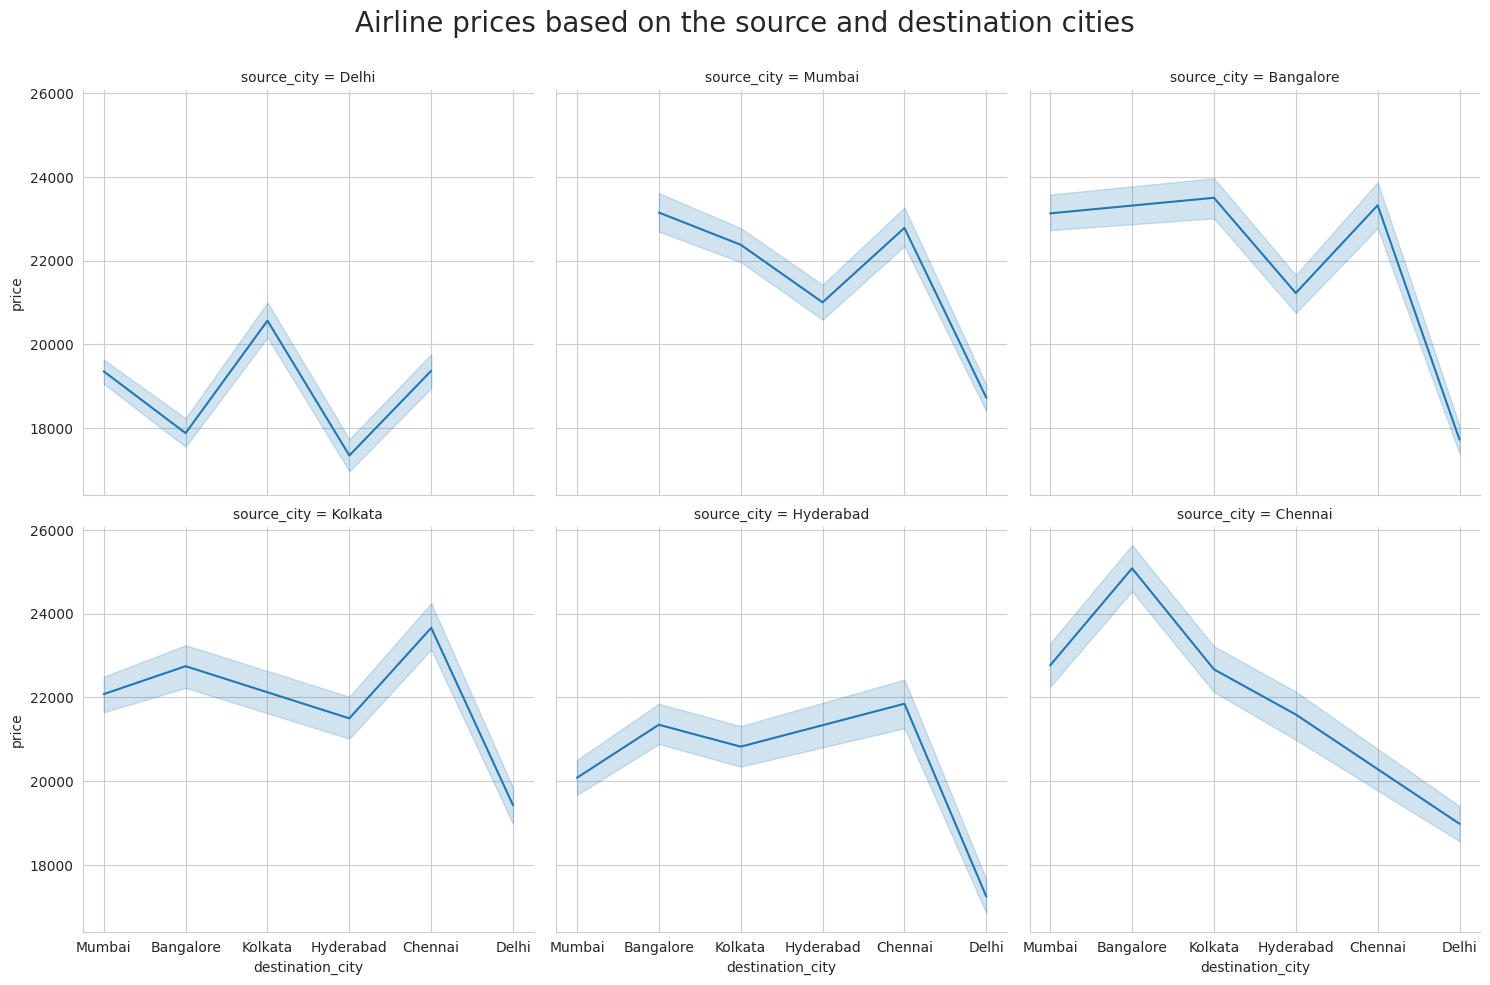

In [17]:
ax = sns.relplot(col="source_city", y="price", kind="line",x='destination_city', data=df, col_wrap=3)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Airline prices based on the source and destination cities',fontsize=20)

On one hand, it seems that flight leaving from Delhi are often cheaper that from other source cities and the capital is also the cheapest deatination to go probably because as a capital cities, the airport is the biggest and proposes more flights. In an other hand, the prices are more or less similar and Hyderabad being the most expensive destination.

Does the number of stops influences the price?

Text(0.5, 1.0, 'Airline prices based on the number of stops  for business')

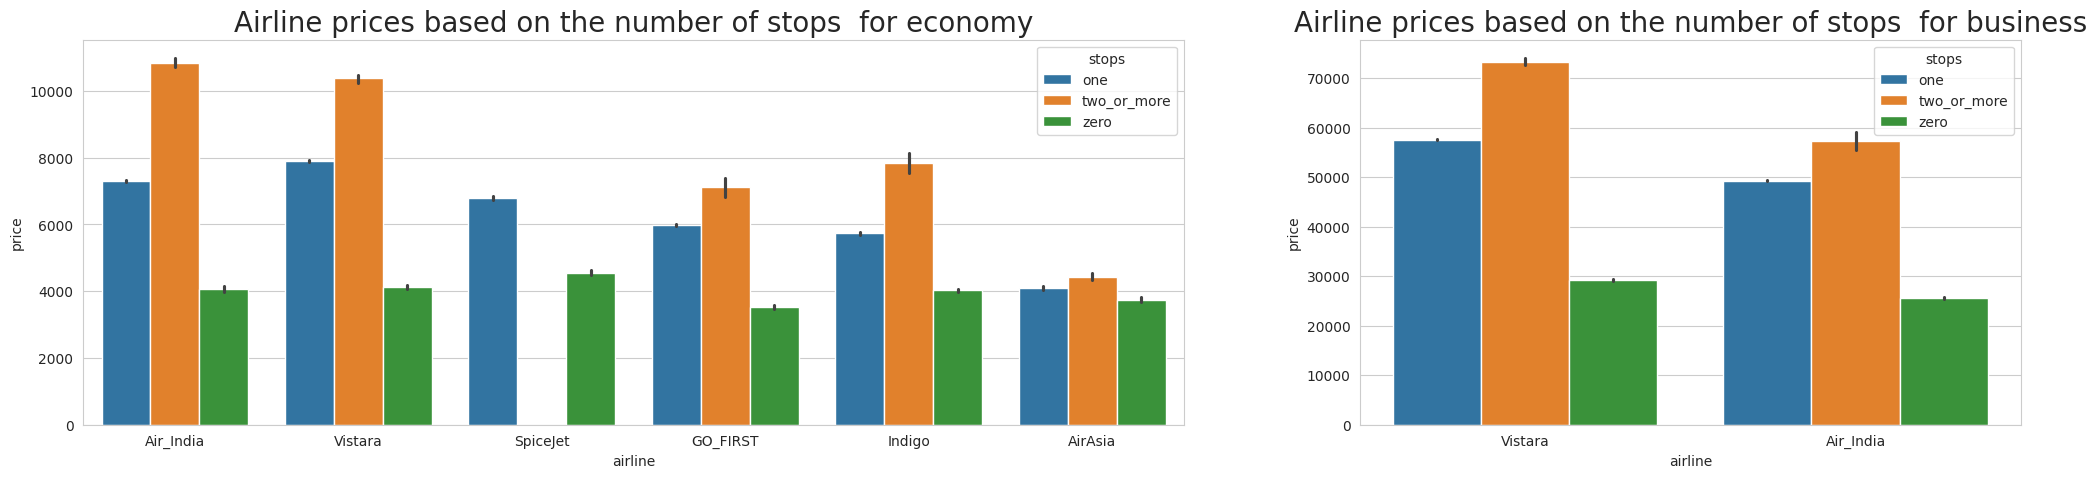

In [18]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), ax=axs[0])
axs[0].set_title("Airline prices based on the number of stops  for economy",fontsize=20)
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), ax=axs[1])
axs[1].set_title("Airline prices based on the number of stops  for business",fontsize=20)

It's clear that the more stops there are the more expensive the flight is except for AirAsia where the prices seems more constant. The behaviour and different analysis of AirAsia tend to show that it relates to a low cost company.

What variables influence most the price?

In [19]:
def preprocessing(df):
    #Encode the ordinal variables "stops" and "class".
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)

    #Create the dummy variables for the cities, the times and the airlines.
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)

    #Create the dummy variables for the cities, the times and the airlines.
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)

    return df

In [20]:
df_preprocessed = preprocessing(df)

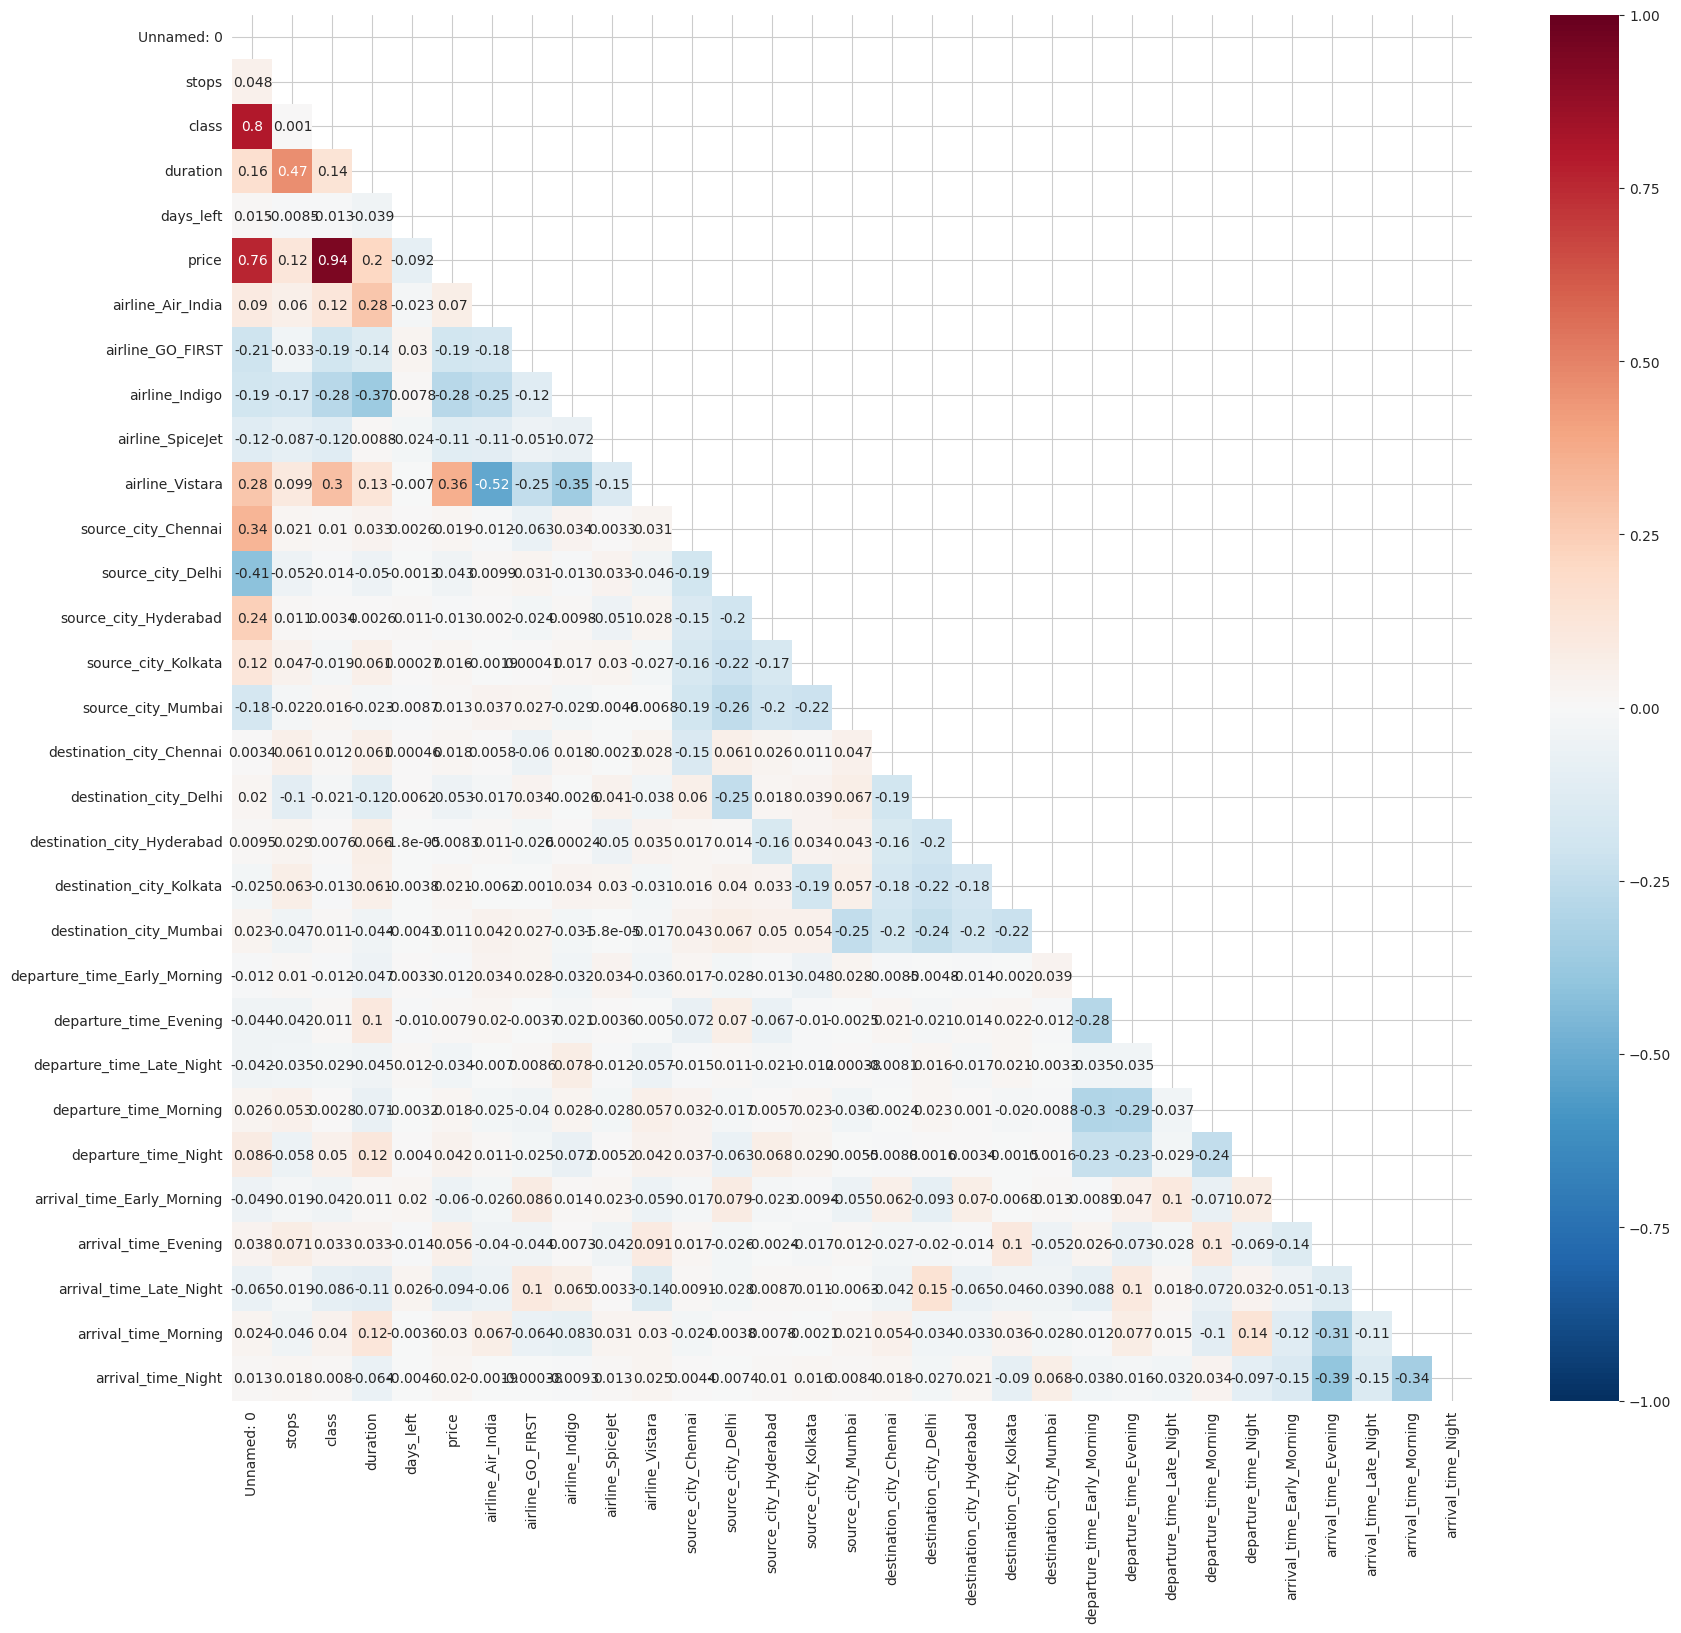

In [22]:
plt.figure(figsize=(20,18))
sns.heatmap(df_preprocessed.corr(), mask=mask, annot=True, vmin=-1.0, vmax=1.0, center=0, cmap='RdBu_r')
plt.show()